In [1]:
import glob
import numpy as np
import urllib
import torch
import cv2
import argparse
import time
import random
import matplotlib.pyplot as plt
import nibabel as nib
import pickle
from nilearn import plotting
from tqdm import tqdm
from torchvision import transforms as trn
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable as V
from sklearn.decomposition import PCA, IncrementalPCA
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
from nilearn import datasets
from nilearn import surface
from decord import VideoReader
from decord import cpu

/home/sungbeenpark/anaconda3/envs/algonauts/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# fMRI Data

The Algonauts dataset provides human brain responses to a set of 1,102 3-s long video clips of everyday events. The brain responses are measured with functional magnetic resonance imaging (fMRI). fMRI is a widely used brain imaging technique with high spatial resolution that measures blood flow changes associated with neural responses.

The training set consists of 1,000 video clips and the associated brain responses. The brain responses are provided here in two tracks corresponding to two independent tracks in the Algonauts challenge.

In the **full track**, brain responses provided are from selected voxels across the whole brain showing reliable responses to videos. The figure below shows the reliability values of different voxels in the brain.

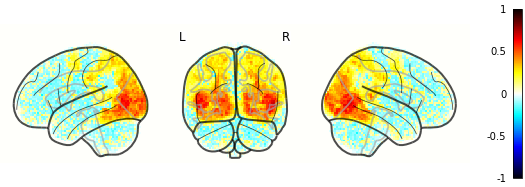

In the **mini track**, brain responses provided are from a set of specific regions of interest (ROIs) known to play a key role in visual perception. These ROIs start in early and mid-level visual cortex (V1, V2, V3, and V4) and extend into higher-level cortex that responds preferentially to all objects or particular categories (Body- EBA; Face - FFA, STS; Object - LOC; Scene - PPA). In the figure below we show the masks of the above mentioned ROIs for an example subject.

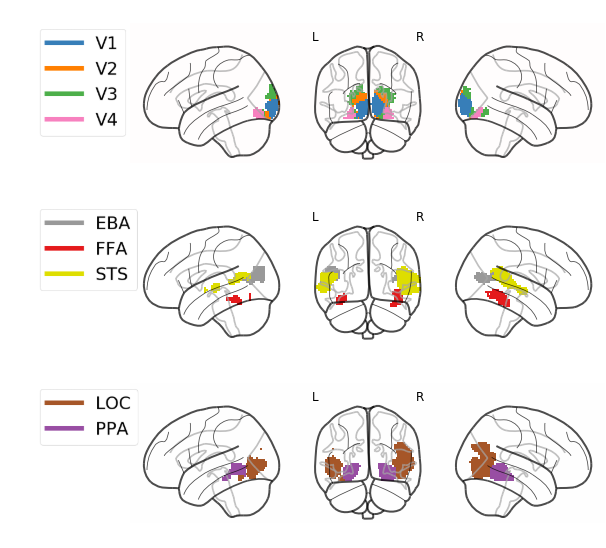

# Loading fMRI data

The trainig dataset contains 1,000 3-second videos + fMRI human brain data of 10 subjects in response to viewing videos from this set. 

The ROI data is provided for 9 ROIs of the visual brain (V1, V2, V3, V4, LOC, EBA, FFA, STS, PPA) in a Pickle file (e.g. V1.pkl) that contains a num_videos x num_repetitions x num_voxels matrix. For each ROI, we selected voxels that showed significant split-half reliability.

The whole brain data is provided for selected voxels across the whole brain showing reliable responses to videos in a Pickle file (e.g. WB.pkl) that contains a num_videos x num_repetitions x num_voxels matrix.

In this section, we demonstrate how to load fMRI data for a given ROI. 

In [3]:
#@title Utility functions for data loading
def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        u = pickle._Unpickler(f)
        ## Using encoding='latin1' is required for unpickling NumPy arrays
        ## and instances of datetime, date and time pickled by Python 2.
        u.encoding = 'latin1'
        ret_di = u.load()
    return ret_di

In [4]:
######## fMRI data loader wrapper code ###################################
dir_root = '/home/sungbeenpark/GoogleDrive/Algonauts_2021_challenge'
dir_fmri = os.path.join(dir_root,'participants_data_v2021')
dir_result = os.path.join(dir_root,'result')
dir_video = os.path.join(dir_root,'AlgonautsVideos268_All_30fpsmax')
os.makedirs(dir_result, exist_ok=True)

In [5]:
brain_mask = os.path.join(dir_root, 'example.nii')

In [6]:
list_subj = ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]
list_ROI = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
list_video = glob.glob(dir_video + '/*.mp4')
list_video.sort()

In [7]:
## title Loading fMRI data and inspecting dimensions
subj = random.sample(list_subj, k=1)[0]
ROI = random.sample(list_ROI, k=1)[0]
# ROI = 'WB'
print(subj, ROI)
#@title Visualize video
video_idx = random.randint(a=0, b=999)

sub04 EBA


In [8]:
def get_fmri(subj, ROI):
    """This function loads fMRI data into a numpy array for to a given ROI.
    Parameters
    ----------
    subj : str
        subject ID
    ROI : str
        name of ROI.
    Returns
    -------
    np.array
        matrix of dimensions #train_vids x #repetitions x #voxels
        containing fMRI responses to train videos of a given ROI
    """

    track = 'full_track' if ROI=='WB' else 'mini_track'
    dir_data = os.path.join(dir_fmri, track, subj) 
    # Loading ROI data
    ROI_file = os.path.join(dir_data, ROI + ".pkl")
    ROI_data = load_dict(ROI_file)
    print(ROI_data.keys())

    # averaging ROI data across repetitions. cf. (video, rep, voxel)
    ROI_data_train = np.mean(ROI_data["train"], axis = 1)
    voxel_mask = ROI_data['voxel_mask'] if ROI == 'WB' else None # (78, 93, 71)

    return ROI_data_train, voxel_mask

---
- cf) shapes
1. Whole brain

In [9]:
data_train, mask = get_fmri(subj=subj, ROI='WB')
print(data_train.shape)
print('mask:', mask.shape)

dict_keys(['train', 'voxel_mask'])
(1000, 12347)
mask: (78, 93, 71)


2. ROIs

In [10]:
for roi in list_ROI[1:]:
    data_train, mask = get_fmri(subj=subj, ROI=roi)
    print(roi, data_train.shape)

dict_keys(['train'])
V1 (1000, 300)
dict_keys(['train'])
V2 (1000, 238)
dict_keys(['train'])
V3 (1000, 223)
dict_keys(['train'])
V4 (1000, 85)
dict_keys(['train'])
LOC (1000, 1244)
dict_keys(['train'])
EBA (1000, 55)
dict_keys(['train'])
FFA (1000, 163)
dict_keys(['train'])
STS (1000, 306)
dict_keys(['train'])
PPA (1000, 150)


---

In [9]:
fmri_train_all, voxel_mask = get_fmri(subj, ROI)

dict_keys(['train'])


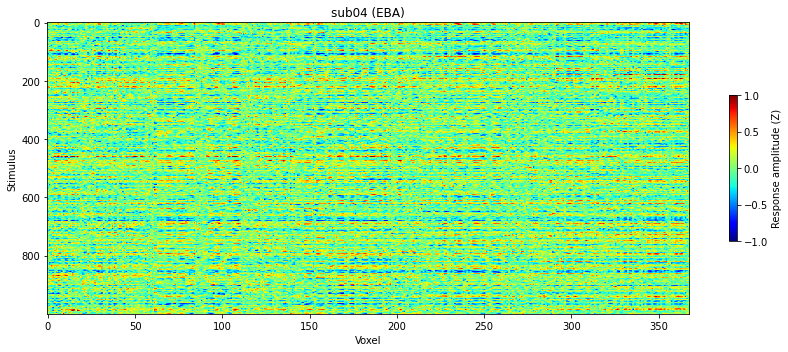

In [10]:
f, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus", title='%s (%s)'%(subj,ROI))
heatmap = ax.imshow(fmri_train_all, aspect="auto",cmap='jet',vmin=-1,vmax=1)
f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
f.tight_layout()

The above matrix shows each individual voxel's (columns) response to 1000 videos (rows). To find out more details about how the fMRI data were preprocessed please click [here](http://algonauts.csail.mit.edu/brainmappingandanalysis.html).

Visualize a given video (with id from 0-999) and its corresponding brain activity

In [11]:
#visualize_brain_activity(video_dir,fmri_train_all,vid_id)
from IPython.display import HTML
from base64 import b64encode

print(list_video[video_idx])
mp4 = open(list_video[video_idx],'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
    <source src="%s" type="video/mp4">
</video>
""" % data_url)
########### Video display code #################################################

/home/sungbeenpark/GoogleDrive/Algonauts_2021_challenge/AlgonautsVideos268_All_30fpsmax/0522_flickr-4-0-7-1-3-2-0-4-3340713204_7.mp4


In [12]:
def saveasnii(brain_mask, fname, nii_data):
    img = nib.load(brain_mask)
    nii_img = nib.Nifti1Image(nii_data, img.affine, img.header)
    nib.save(nii_img, fname)
    
def visualize_activity(video_idx, subj):
    train_whole_brain, voxel_mask = get_fmri(os.path.join(dir_fmri,'full_track',subj), "WB")
    visual_mask_3D = np.zeros((78,93,71))
    visual_mask_3D[voxel_mask==1] = train_whole_brain[video_idx,:]

    fname = os.path.join(dir_result, 'vid_activity.nii')
    saveasnii(brain_mask, fname, visual_mask_3D)
    plotting.plot_glass_brain(fname,
                          title='fMRI response',plot_abs=False,
                          display_mode='lyr',colorbar=True)

dict_keys(['train', 'voxel_mask'])


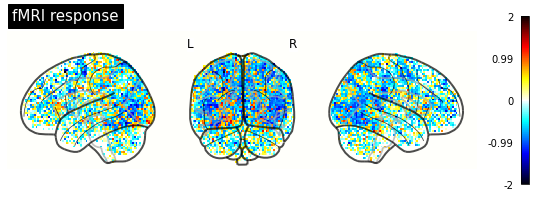

In [13]:
#@title Visualize corresponding brain response
visualize_activity(video_idx, subj)

The values in the fMRI response above correspond to beta values from 5s to 9s after stimulus onset calculated using an Finite Impulse Response (FIR) model. The beta values were averaged across time and z-scored across videos. 

# Vision Model definition (AlexNet)

Run the next cell to define the architecture of the model using pytorch.

In [14]:
#@title AlexNet
__all__ = ['AlexNet', 'alexnet']

model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.fc6 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            )
        self.fc7 =nn.Sequential(
            nn.Dropout(),
            nn.Linear(4096, 4096),
            )
        self.fc8 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            )

    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.conv2(out1)
        out3 = self.conv3(out2)
        out4 = self.conv4(out3)
        out5 = self.conv5(out4)

        out5_reshaped = out5.view(out5.size(0), 256 * 6 * 6)
        out6= self.fc6(out5_reshaped)
        out7= self.fc7(out6)
        out8 = self.fc8(out7)
        return out1, out2, out3, out4, out5, out6, out7, out8


def alexnet(pretrained=False, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = AlexNet(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
    return model

---

In [15]:
model = AlexNet().to(device)
print(model)

AlexNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (conv5): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc6): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_fe

In [18]:
## model test
value = torch.Tensor(1,3,227,227).to(device)
print('input.shape =', value.shape)
for i, layer in enumerate(model(value)):
    print('i = %d : layer.shape = %s'%(i, layer.shape))

input.shape = torch.Size([1, 3, 227, 227])
i = 0 : layer.shape = torch.Size([1, 64, 27, 27])
i = 1 : layer.shape = torch.Size([1, 192, 13, 13])
i = 2 : layer.shape = torch.Size([1, 384, 13, 13])
i = 3 : layer.shape = torch.Size([1, 256, 13, 13])
i = 4 : layer.shape = torch.Size([1, 256, 6, 6])
i = 5 : layer.shape = torch.Size([1, 4096])
i = 6 : layer.shape = torch.Size([1, 4096])
i = 7 : layer.shape = torch.Size([1, 1000])


/home/sungbeenpark/anaconda3/envs/algonauts/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


---

In [15]:
def load_alexnet(model_checkpoints):
    """This function initializes an Alexnet and load
    its weights from a pretrained model
    ----------
    model_checkpoints : str
        model checkpoints location.
    Returns
    -------
    model
        pytorch model of alexnet
    """
    model = alexnet()
    model_file = model_checkpoints
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    model_dict =["conv1.0.weight", "conv1.0.bias", "conv2.0.weight", "conv2.0.bias", "conv3.0.weight", "conv3.0.bias", "conv4.0.weight", "conv4.0.bias", "conv5.0.weight", "conv5.0.bias", "fc6.1.weight", "fc6.1.bias", "fc7.1.weight", "fc7.1.bias", "fc8.1.weight", "fc8.1.bias"]
    state_dict={}
    i=0
    for k,v in checkpoint.items():
        state_dict[model_dict[i]] =  v
        i+=1

    model.load_state_dict(state_dict)
    if torch.cuda.is_available():
        model.cuda()
    ## model.eval() : evaluation 과정에서 사용하지 않아야 하는 layer들을 off. e.g.) Dropout layer, BatchNorm layer
    model.eval()
    return model

# load Alexnet
# Download pretrained Alexnet from:
# https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth
# and save in the current directory
checkpoint_path = os.path.join(dir_root, 'alexnet.pth')
if not os.path.exists(checkpoint_path):
    url = "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth"
    urllib.request.urlretrieve(url, os.path.join(dir_root, 'alexnet.pth'))
model = load_alexnet(checkpoint_path)
print(model)

AlexNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (conv5): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc6): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_fe

In [16]:
def sample_video_from_mp4(file, num_frames=16):
    """This function takes a mp4 video file as input and returns
    a list of uniformly sampled frames (PIL Image).
    Parameters
    ----------
    file : str
        path to mp4 video file
    num_frames : int
        how many frames to select using uniform frame sampling.
    Returns
    -------
    images: list of PIL Images
    num_frames: int
        number of frames extracted
    """
    images = list()
    vr = VideoReader(file, ctx=cpu(0))
    total_frames = len(vr)
    indices = np.linspace(0,total_frames-1,num_frames,dtype=np.int)
    for seg_ind in indices:
        images.append(Image.fromarray(vr[seg_ind].asnumpy()))

    return images, num_frames

# Feature Extraction
Run the next cell to extract Alexnet activations on the videos from the stimulus set. We will use these later to train a regression for predicting fMRI responses. 

In [17]:
def print_alexnet_predictions(output):
    with open(os.path.join(dir_root,'class_names_ImageNet.txt')) as labels:
        classes = [i.strip() for i in labels.readlines()]

    # sort the probability vector in descending order
    sorted, indices = torch.sort(output, descending=True)
    percentage = F.softmax(output, dim=1)[0] * 100.0
    # obtain the first 5 classes (with the highest probability) the input belongs to
    results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
    for i in range(5):
        print('{}: {:.4f}%'.format(results[i][0], results[i][1]))

---

In [18]:
vpath = list_video[0]
vname = os.path.split(vpath)[-1].split(".")[0]
print(vpath, '/', vname)

/home/sungbeenpark/GoogleDrive/Algonauts_2021_challenge/AlgonautsVideos268_All_30fpsmax/0001_0-0-1-6-7-2-8-0-17500167280.mp4 / 0001_0-0-1-6-7-2-8-0-17500167280


In [19]:
video, num_frames = sample_video_from_mp4(vpath)

/tmp/ipykernel_825384/91555205.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = np.linspace(0,total_frames-1,num_frames,dtype=np.int)


In [50]:
activations = []

for frame, img in enumerate(video):
    print('Frame = %d : %s'%(frame, img))
    ## In the normalization, using the mean and std of Imagenet is a common practice.
    resize_normalize = trn.Compose([
            trn.Resize((227,227)),
            trn.ToTensor(),
            trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    resize_normalize(img).unsqueeze(0)
    input_img = V(resize_normalize(img).unsqueeze(0))
    print('input_img.shape =', input_img.shape)
    if torch.cuda.is_available():
        input_img=input_img.cuda()
    x = model.forward(input_img)
    for layer, feat in enumerate(x):
        if frame==0:
            ## 0 <= layer <= 7. an index of layer
            if layer==7:
                print("\nTop-5 Predictions for the video id: ", vname)
                print_alexnet_predictions(feat)
            activations.append(feat.data.cpu().numpy().ravel())
        else:
            activations[layer] =  activations[layer] + feat.data.cpu().numpy().ravel()

Frame = 0 : <PIL.Image.Image image mode=RGB size=268x268 at 0x7F86B49E4DC0>
input_img.shape = torch.Size([1, 3, 227, 227])

Top-5 Predictions for the video id:  0001_0-0-1-6-7-2-8-0-17500167280
red-breasted merganser, Mergus serrator: 65.1377%
American coot, marsh hen, mud hen, water hen, Fulica americana: 19.3967%
drake: 5.0225%
oystercatcher, oyster catcher: 2.8978%
goose: 1.3234%
Frame = 1 : <PIL.Image.Image image mode=RGB size=268x268 at 0x7F86B49E4970>
input_img.shape = torch.Size([1, 3, 227, 227])
Frame = 2 : <PIL.Image.Image image mode=RGB size=268x268 at 0x7F86B49E4550>
input_img.shape = torch.Size([1, 3, 227, 227])
Frame = 3 : <PIL.Image.Image image mode=RGB size=268x268 at 0x7F86B49E4760>
input_img.shape = torch.Size([1, 3, 227, 227])
Frame = 4 : <PIL.Image.Image image mode=RGB size=268x268 at 0x7F86B49E45E0>
input_img.shape = torch.Size([1, 3, 227, 227])
Frame = 5 : <PIL.Image.Image image mode=RGB size=268x268 at 0x7F86B49E4730>
input_img.shape = torch.Size([1, 3, 227, 227])

In [27]:
print(64*27*27)
print(192*13*13)
print(384*13*13)
print(256*13*13)
print(256*6*6)
for i, act in enumerate(activations):
    print('i = %d : %d'%(i,len(act)))

46656
32448
64896
43264
9216
i = 0 : 46656
i = 1 : 32448
i = 2 : 64896
i = 3 : 43264
i = 4 : 9216
i = 5 : 4096
i = 6 : 4096
i = 7 : 1000


---

In [18]:
#@title Functions for loading videos and extracting features
seed = 42
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
random.seed(seed)

def get_activations_and_save(model, video_list, dir_activations):
    """This function generates Alexnet features and save them in a specified directory.
    Parameters
    ----------
    model :
        pytorch model : alexnet.
    video_list : list
        the list contains path to all videos.
    dir_activations : str
        save path for extracted features.
    """

    resize_normalize = trn.Compose([
            trn.Resize((224,224)),
            trn.ToTensor(),
            trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    for video_file in tqdm(video_list):
        vid,num_frames = sample_video_from_mp4(video_file)
        video_file_name = os.path.split(video_file)[-1].split(".")[0]
        activations = []
        for frame,img in enumerate(vid):
            input_img = V(resize_normalize(img).unsqueeze(0))
            if torch.cuda.is_available():
                input_img=input_img.cuda()
            x = model.forward(input_img)
            for i,feat in enumerate(x):
                if frame==0:
                    if i==7:
                        print("\nTop-5 Predictions for the video id: ", video_file_name)
                        print_alexnet_predictions(feat)
                    activations.append(feat.data.cpu().numpy().ravel())
                else:
                    activations[i] =  activations[i] + feat.data.cpu().numpy().ravel()
        for layer in range(len(activations)):
            save_path = os.path.join(dir_activations, video_file_name+"_"+"layer" + "_" + str(layer+1) + ".npy")
            avg_layer_activation = activations[layer]/float(num_frames)
            np.save(save_path,avg_layer_activation)

In [22]:
# # print('Total Number of Videos: ', len(list_video))

# # # get and save activations
# dir_save = os.path.join(dir_result, 'activations_alexnet')
# dir_activation = os.path.join(dir_save)
# os.makedirs(dir_activation, exist_ok=True)
# print("-------------Saving activations ----------------------------")
# get_activations_and_save(model, list_video, dir_activation)

-------------Saving activations ----------------------------


  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_1914270/91555205.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = np.linspace(0,total_frames-1,num_frames,dtype=np.int)
/home/sungbeenpark/anaconda3/envs/algonauts/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torc


Top-5 Predictions for the video id:  0007_0-2-3-14056753023
restaurant, eating house, eating place, eatery: 80.9636%
fire screen, fireguard: 1.4943%
cello, violoncello: 0.9887%
academic gown, academic robe, judge's robe: 0.8595%
palace: 0.7588%


100%|██████████| 1/1 [00:29<00:00, 29.08s/it]


In [19]:
def do_PCA_and_save(activations_dir, save_dir):
    """This function preprocesses Neural Network features using PCA and save the results
    in  a specified directory
.
    Parameters
    ----------
    activations_dir : str
        save path for extracted features.
    save_dir : str
        save path for extracted PCA features.
    """

    layers = ['layer_1','layer_2','layer_3','layer_4','layer_5','layer_6','layer_7','layer_8']
    n_components = 100
    os.makedirs(save_dir, exist_ok=True)
    
    for layer in tqdm(layers):
        activations_file_list = glob.glob(activations_dir +'/*'+layer+'.npy')
        activations_file_list.sort()
        feature_dim = np.load(activations_file_list[0])
        x = np.zeros((len(activations_file_list),feature_dim.shape[0]))
        for i,activation_file in enumerate(activations_file_list):
            temp = np.load(activation_file)
            x[i,:] = temp
        x_train = x[:1000,:]  ## 1000 videos
        x_test = x[1000:,:]   ## 102 videos

        start_time = time.time()
        x_test = StandardScaler().fit_transform(x_test)
        x_train = StandardScaler().fit_transform(x_train)
        ipca = PCA(n_components=n_components,random_state=seed)
        ipca.fit(x_train)

        x_train = ipca.transform(x_train)
        x_test = ipca.transform(x_test)
        train_save_path = os.path.join(save_dir,"train_"+layer)
        test_save_path = os.path.join(save_dir,"test_"+layer)
        np.save(train_save_path,x_train)
        np.save(test_save_path,x_test)

In [ ]:
# # preprocessing using PCA and save
# dir_save = os.path.join(dir_result, 'pca')

# print("-------------performing  PCA----------------------------")
# do_PCA_and_save(dir_activation, dir_save)

# Voxel Wise Encoding

The approach has three steps: 

1. Features of a computer vision model to videos are extracted (Fig. 1A). This changes the format of the data (from pixels to model features) and typically reduces the dimensionality of the data. The features of a given model are interpreted as a potential hypothesis about the features that a given brain area might be using to represent the stimulus. 
2. Features of the computational model are linearly mapped onto each voxel's responses (Fig. 1B) using the training set provided. This step is necessary as there is not necessarily a one-to-one mapping between voxels and model features. Instead, each voxel's response is hypothesized to correspond to a weighted combination of activations of multiple features of the model. 
3. The estimated mapping from the training dataset is applied on the model features corresponding to videos in the test set to predict synthetic brain data (Fig. 1C). The predicted synthetic brain data is then compared against the ground-truth left out brain data in the testing set. 

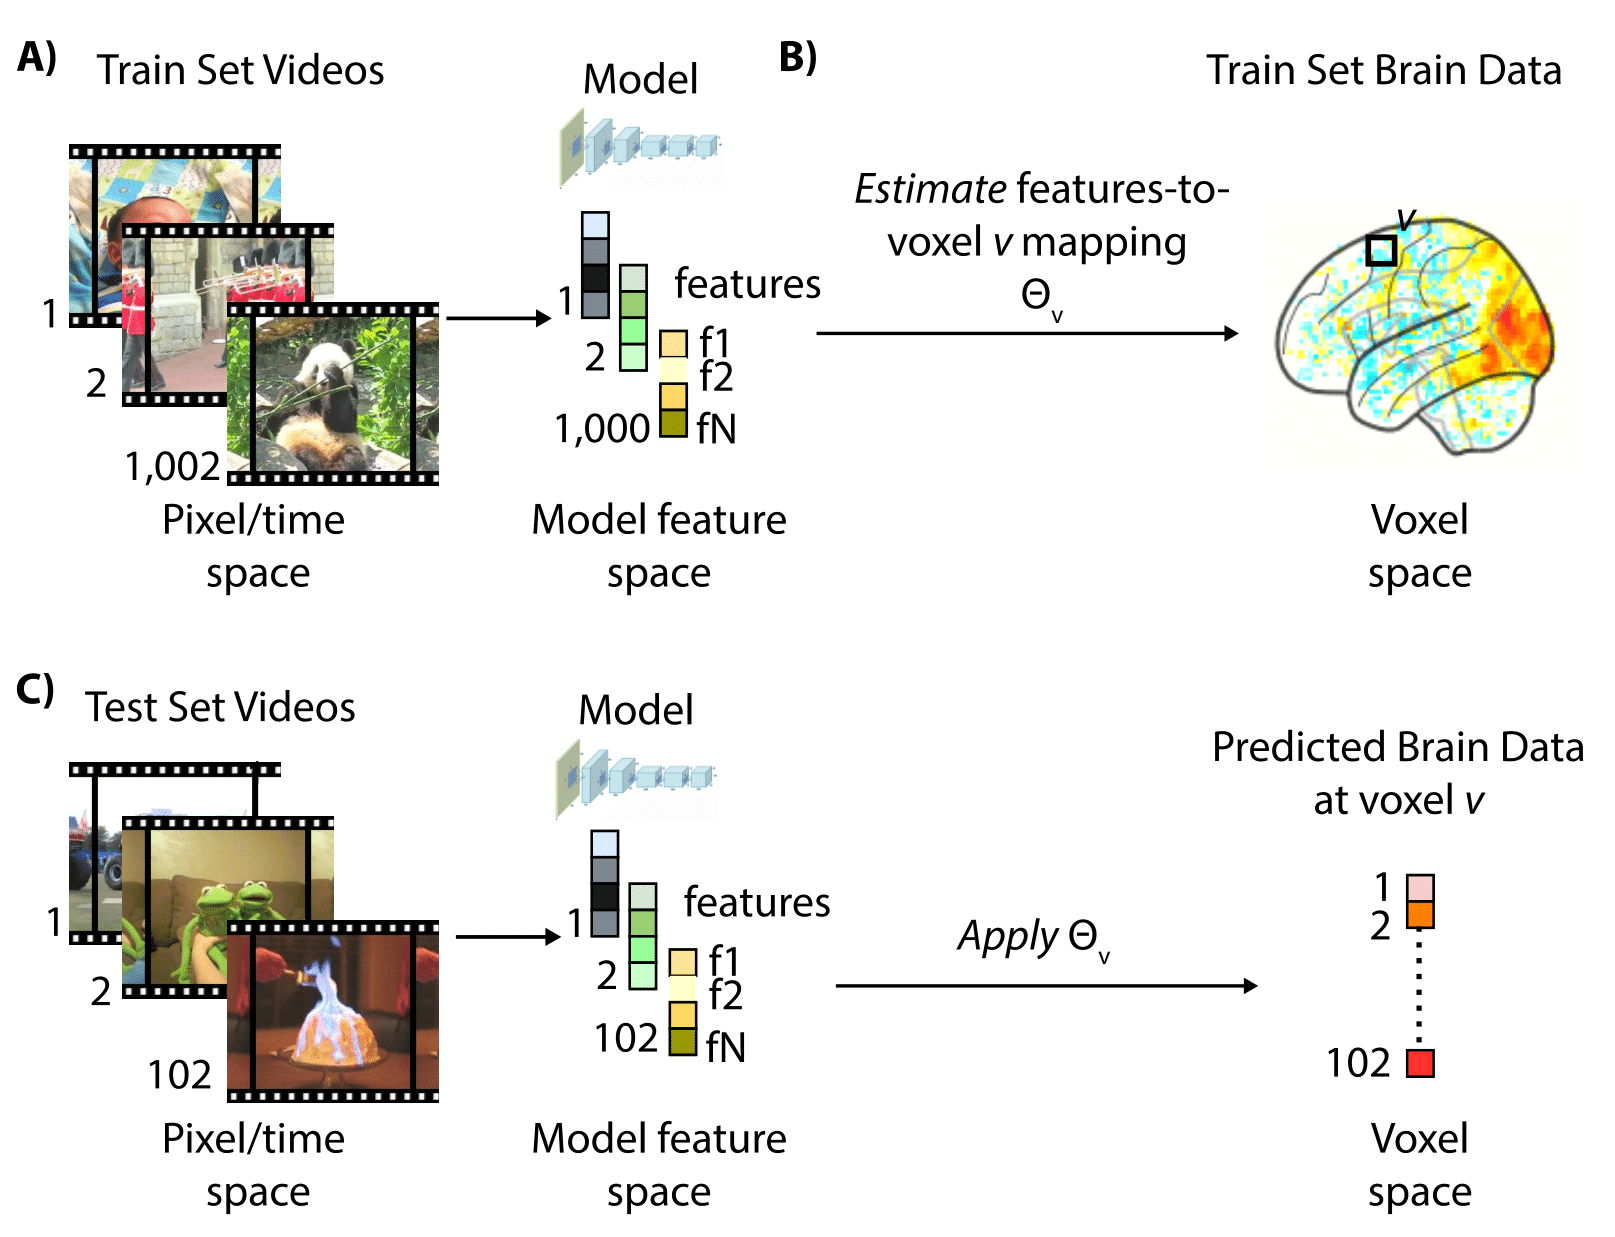

**Figure 1**: **A)** First, given the training set videos, the features of a computational model are extracted. **B)** A mapping between model features and brain voxels is estimated from the Training Set videos. **C)** A mapping between model features and brain voxels is generated on the test set videos, therefore, generating a predicted voxel v's activity for a given video.

## Evaluation

To determine how well a model predicts brain responses we compare synthetic brain data (i.e. those predicted from your model to the left out video clips) to the empirically measured brain responses. The comparison is carried out using Pearson's correlation, comparing for each voxel the 100-dimensional vector formed by the activations for the 100 validation set video clips.

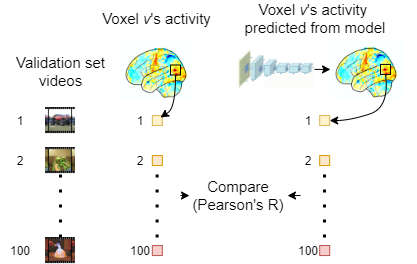

In [20]:
#@title Utility functions for regression
def vectorized_correlation(x,y):
    ## 베셀 보정 (n-1) 한 Pearson correlation
    dim = 0

    centered_x = x - x.mean(axis=dim, keepdims=True)
    centered_y = y - y.mean(axis=dim, keepdims=True)

    covariance = (centered_x * centered_y).sum(axis=dim, keepdims=True)

    bessel_corrected_covariance = covariance / (x.shape[dim] - 1)

    x_std = x.std(axis=dim, keepdims=True)+1e-8
    y_std = y.std(axis=dim, keepdims=True)+1e-8

    corr = bessel_corrected_covariance / (x_std * y_std)

    return corr.ravel()

---

In [77]:
from scipy.stats import pearsonr

a = np.random.rand(10)
b = np.random.rand(10)

print(pearsonr(a,b))

print(vectorized_correlation(a,b))

(0.1501648836099866, 0.678821823566329)
[0.16684986]


---

In [21]:
def get_activations(activations_dir, layer_name):
    """This function loads neural network features/activations (preprocessed using PCA) into a
    numpy array according to a given layer.
    Parameters
    ----------
    activations_dir : str
        Path to PCA processed Neural Network features
    layer_name : str
        which layer of the neural network to load,
    Returns
    -------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos
    test_activations : np.array
        matrix of dimensions #test_vids x #pca_components
        containing activations of test videos
    """

    train_file = os.path.join(activations_dir,"train_" + layer_name + ".npy")
    test_file = os.path.join(activations_dir,"test_" + layer_name + ".npy")
    train_activations = np.load(train_file)
    test_activations = np.load(test_file)
    scaler = StandardScaler()
    train_activations = scaler.fit_transform(train_activations)
    test_activations = scaler.fit_transform(test_activations)

    return train_activations, test_activations

In [22]:
class OLS_pytorch(object):
    def __init__(self,use_gpu=False):
        self.coefficients = []
        self.use_gpu = use_gpu
        self.X = None
        self.y = None

    def fit(self,X,y):
        if len(X.shape) == 1:
            X = self._reshape_x(X)
        if len(y.shape) == 1:
            y = self._reshape_x(y)

        X = self._concatenate_ones(X)

        X = torch.from_numpy(X).float()
        y = torch.from_numpy(y).float()
        if self.use_gpu:
            X = X.cuda()
            y = y.cuda()
        XtX = torch.matmul(X.t(),X)
        Xty = torch.matmul(X.t(),y.unsqueeze(2))
        XtX = XtX.unsqueeze(0)
        XtX = torch.repeat_interleave(XtX, y.shape[0], dim=0)
        betas_cholesky, _ = torch.solve(Xty, XtX)

        self.coefficients = betas_cholesky

    def predict(self, entry):
        if len(entry.shape) == 1:
            entry = self._reshape_x(entry)
        entry = self._concatenate_ones(entry)
        entry = torch.from_numpy(entry).float()
        if self.use_gpu:
            entry = entry.cuda()
        prediction = torch.matmul(entry,self.coefficients)
        prediction = prediction.cpu().numpy()
        prediction = np.squeeze(prediction).T
        return prediction

    def _reshape_x(self,X):
        return X.reshape(-1,1)

    def _concatenate_ones(self,X):
        ones = np.ones(shape=X.shape[0]).reshape(-1,1)
        return np.concatenate((ones,X),1)

def predict_fmri_fast(train_activations, test_activations, train_fmri, use_gpu=False):
    """This function fits a linear regressor using train_activations and train_fmri,
    then returns the predicted fmri_pred_test using the fitted weights and
    test_activations.
    Parameters
    ----------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos.
    test_activations : np.array
        matrix of dimensions #test_vids x #pca_components
        containing activations of test videos
    train_fmri : np.array
        matrix of dimensions #train_vids x  #voxels
        containing fMRI responses to train videos
    use_gpu : bool
        Description of parameter `use_gpu`.
    Returns
    -------
    fmri_pred_test: np.array
        matrix of dimensions #test_vids x  #voxels
        containing predicted fMRI responses to test videos .
    """

    reg = OLS_pytorch(use_gpu)
    reg.fit(train_activations, train_fmri.T)
    fmri_pred_test = reg.predict(test_activations)
    return fmri_pred_test    

In [26]:
def perform_encoding(pca_dir, fmri_dir,results_dir, sub, layer, ROI = 'WB', mode = 'val', visualize_results = True\
                     , batch_size=1000):
    if torch.cuda.is_available():
        use_gpu = True
    else:
        use_gpu = False

    ###### Load activations ##############
    train_activations,test_activations = get_activations(pca_dir, layer)
    ######################################

    ##### Load fMRI data #################
    fmri_train_all, voxel_mask = get_fmri(os.path.join(fmri_dir, track, subj),ROI)

    num_voxels = fmri_train_all.shape[1]
    ######################################


    #### Creating data splits ###############
    if mode == 'val':
        # Here as an example we use first 900 videos as training and rest of the videos as validation
        test_activations = train_activations[900:,:]
        train_activations = train_activations[:900,:]
        fmri_train = fmri_train_all[:900,:]
        fmri_test = fmri_train_all[900:,:]
        pred_fmri = np.zeros_like(fmri_test)
        pred_fmri_save_path = os.path.join(results_dir, ROI + '_val.npy')
    else:
        fmri_train = fmri_train_all
        num_test_videos = 102
        pred_fmri = np.zeros((num_test_videos,num_voxels))
        pred_fmri_save_path = os.path.join(results_dir, ROI + '_test.npy')
    ######################################

    ######## Performing regression ################
    iter = 0

    while iter < num_voxels-batch_size:
        pred_fmri[:,iter:iter+batch_size] = predict_fmri_fast(train_activations,test_activations,fmri_train[:,iter:iter+batch_size], use_gpu = use_gpu)
        iter = iter+batch_size
    pred_fmri[:,iter:] = predict_fmri_fast(train_activations,test_activations,fmri_train[:,iter:iter+batch_size], use_gpu = use_gpu)
    if mode == 'val':
        score = vectorized_correlation(fmri_test, pred_fmri)
        print("----------------------------------------------------------------------------")
        print("Mean correlation for ROI : ",ROI, "in ",sub," using ",layer, " is :", round(score.mean(), 6))
        ################################################

        nii_save_path =  os.path.join(results_dir, ROI + '_val.nii')
        ######## Result visualization ################
        if track == "full_track" and visualize_results:
            visual_mask_3D = np.zeros((78,93,71))
            visual_mask_3D[voxel_mask==1] = score
            brain_mask = '/content/example.nii'
            saveasnii(brain_mask, nii_save_path, visual_mask_3D)
            plotting.plot_glass_brain(nii_save_path, plot_abs=False,
                              title = 'Correlation for ' + sub + ' and ' + layer,
                              display_mode='lyr', colorbar=True,vmin=-1,vmax=1)

        ################################################

    np.save(pred_fmri_save_path, pred_fmri)


If you use the default parameters (sub04, EBA, layer_5) you should obtain a correlation of 0.219 between predicted and recorded fMRI responses on validation videos.

# Predict fMRI responses to test videos for all subjects all ROIs
Run the cell below to save predicted fMRI responses to test videos for all subjects and ROIs.

In [27]:
subs = ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  
ROIs = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
layer = 'layer_5'
model = 'alexnet'

dir_pca = os.path.join(dir_result, 'pca')
for sub in subs:
    for ROI in ROIs:
        track = 'full_track' if ROI=='WB' else 'mini_track'
        print ("Starting ROI: ", ROI, "sub: ",sub)
        dir_output = os.path.join(dir_result, 'pred', model, layer, track, sub)
        os.makedirs(dir_output, exist_ok=True)

        perform_encoding(dir_pca, dir_fmri, dir_output, sub, layer, ROI=ROI, mode='test')
        print ("Completed ROI: ", ROI, "sub: ",sub)
        print("----------------------------------------------------------------------------")

Starting ROI:  WB sub:  sub01
dict_keys(['train', 'voxel_mask'])
Completed ROI:  WB sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V1 sub:  sub01
dict_keys(['train'])
Completed ROI:  V1 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V2 sub:  sub01
dict_keys(['train'])
Completed ROI:  V2 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V3 sub:  sub01
dict_keys(['train'])
Completed ROI:  V3 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V4 sub:  sub01
dict_keys(['train'])
Completed ROI:  V4 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  LOC sub:  sub01
dict_keys(['train'])
Completed ROI:  LOC sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  EBA sub:  sub01

dict_keys(['train'])
Completed ROI:  V1 sub:  sub06
----------------------------------------------------------------------------
Starting ROI:  V2 sub:  sub06
dict_keys(['train'])
Completed ROI:  V2 sub:  sub06
----------------------------------------------------------------------------
Starting ROI:  V3 sub:  sub06
dict_keys(['train'])
Completed ROI:  V3 sub:  sub06
----------------------------------------------------------------------------
Starting ROI:  V4 sub:  sub06
dict_keys(['train'])
Completed ROI:  V4 sub:  sub06
----------------------------------------------------------------------------
Starting ROI:  LOC sub:  sub06
dict_keys(['train'])
Completed ROI:  LOC sub:  sub06
----------------------------------------------------------------------------
Starting ROI:  EBA sub:  sub06
dict_keys(['train'])
Completed ROI:  EBA sub:  sub06
----------------------------------------------------------------------------
Starting ROI:  FFA sub:  sub06
dict_keys(['train'])
Completed ROI:  FFA 

---

In [29]:
subj = random.sample(list_subj, k=1)[0]
ROI = random.sample(list_ROI, k=1)[0]

track = 'full_track' if ROI=='WB' else 'mini_track'

layer = 'layer_5'
model = 'alexnet'

In [32]:
fmri_pred = np.load(os.path.join(dir_result, 'pred', model, layer, track, subj, '%s_test.npy'%ROI))

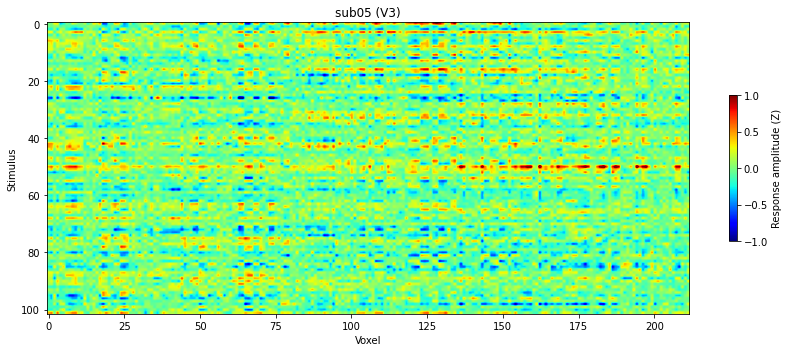

In [35]:
f, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus", title='%s (%s)'%(subj,ROI))
heatmap = ax.imshow(fmri_pred, aspect="auto",cmap='jet',vmin=-1,vmax=1)
f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
f.tight_layout()

---

# Prepare submission files

Now, we will prepare the zipfiles for submission to codalab. After running the two cells below you will see a Pickle and a zip file (containing the Pickle file) for the corresponding track in the colab file directory. 

Submit the mini_track results [here](https://competitions.codalab.org/competitions/30930#participate-submit_results) and full_track results [here](https://competitions.codalab.org/competitions/30937#participate-submit_results)

In [ ]:
def prepare_results(submission_dir, track):
    if track == 'full_track':
        ROIs = ['WB']
    else:
        ROIs = ['LOC','FFA','STS','EBA','PPA','V1','V2','V3','V4']

    num_subs = 10
    subs=[]
    for s in range(num_subs):
        subs.append('sub'+str(s+1).zfill(2))

    results = {}
    for ROI in ROIs:
        ROI_results = {}
        for sub in subs:
            ROI_result_file = os.path.join(submission_dir,track,sub,ROI+"_test.npy")
            if not os.path.exists(ROI_result_file):
                print("---------Warning : submission not ready ----------")
                print("Result not found for ",sub, " and ROI: ",ROI)
                print("Result file path: ", ROI_result_file)
                print("Please check if the directory is correct or generate predicted data for ROI: ",ROI , " in subject: ", sub)
                return
            ROI_result = np.load(ROI_result_file)
            ROI_results[sub] = ROI_result
        results[ROI] = ROI_results

    save_dict(results,track+".pkl")
    zipped_results = zipfile.ZipFile(track+".zip", 'w')
    zipped_results.write(track+".pkl")
    zipped_results.close()

In [ ]:
import zipfile

submission_dir = '/content/prediction/alexnet/layer_5'
prepare_results(submission_dir, 'full_track')
prepare_results(submission_dir, 'mini_track')

Click the folder button on the left panel and you should see zipfiles ready for submission

# Reference

[The Algonauts Project 2021 Challenge: How the Human Brain Makes Sense of a World in Motion. 
*Cichy et al. arxiv 2021*](https://arxiv.org/abs/2104.13714v1)